## Active Charging Slots for Summer and Winter Schedule

/var/folders/bl/yk68mgqn3m50dq5pbmwy3w6w0000gn/T/ipykernel_20557/3449443829.py:27: MatplotlibDeprecationWarning: The BrokenBarHCollection class was deprecated in Matplotlib 3.7 and will be removed two minor releases later.
  coll = BrokenBarHCollection(


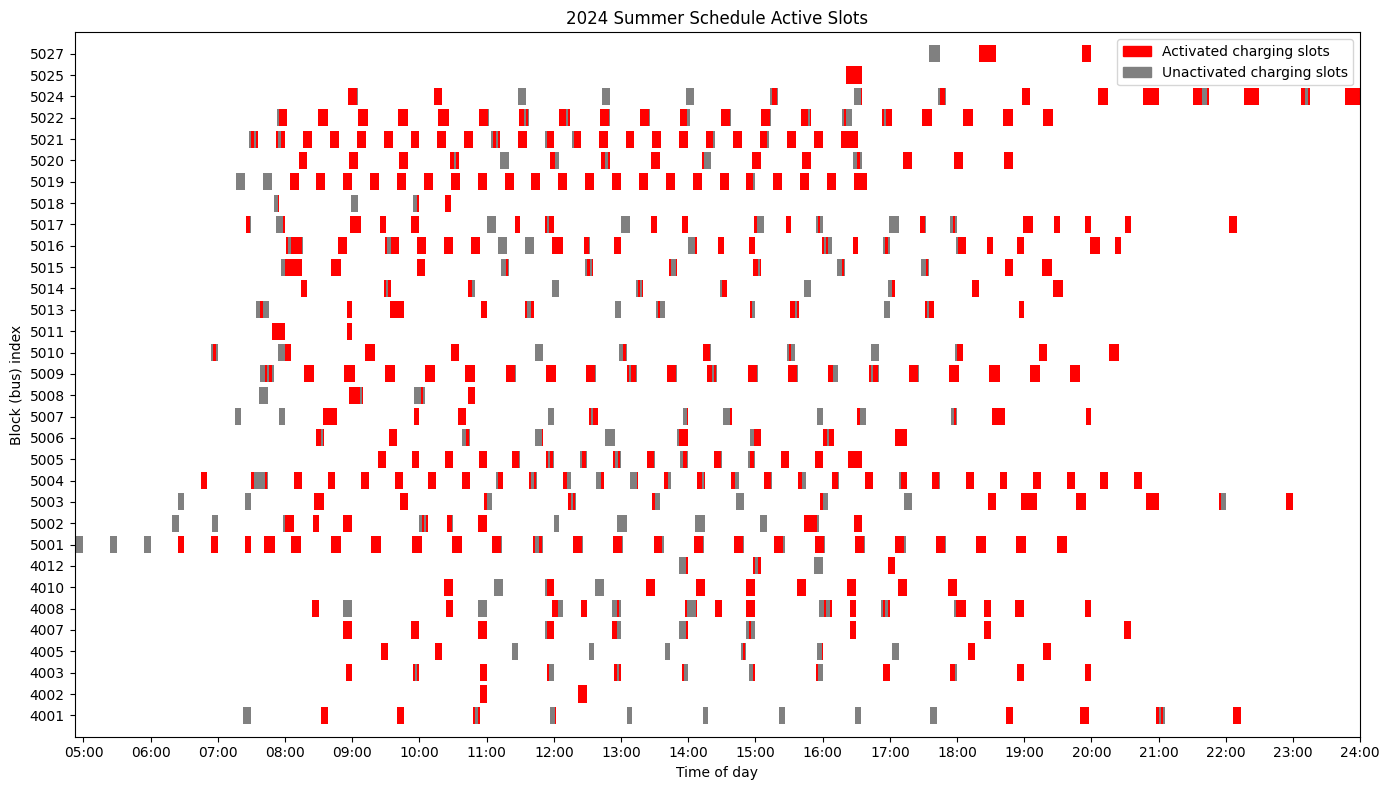

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import BrokenBarHCollection
from matplotlib.patches import Patch
import matplotlib.ticker as ticker

rate_kwh_per_min = 5      
x_result_path = "SU_output/x_results.csv"

df = pd.read_csv(x_result_path)
df["slot_len"] = df["q_kwh"] / rate_kwh_per_min

bus_ids = sorted(df["bus_id"].unique())
bus_map = {bid: idx for idx, bid in enumerate(bus_ids)}
df["bus_index"] = df["bus_id"].map(bus_map)

active = df[df["x"] > 0.5].copy()
inactive = df[df["x"] <= 0.5].copy()

fig, ax = plt.subplots(figsize=(14, 8))

def add_bars(sub_df, color):
    for bus_idx, g in sub_df.groupby("bus_index"):
        bars = list(zip(g["slot_start_min"], g["slot_len"]))
        if not bars:
            continue
        coll = BrokenBarHCollection(
            bars,
            (bus_idx - 0.4, 0.8),    
            facecolors=color,
            edgecolors="none",
        )
        ax.add_collection(coll)

add_bars(inactive, "red")
add_bars(active, "grey")

xmin = df["slot_start_min"].min()
xmax = (df["slot_start_min"] + df["slot_len"]).max()
ax.set_xlim(xmin, xmax)
ax.set_ylim(-1, len(bus_ids))

def minutes_to_hhmm(x, pos):
    h = int(x // 60)
    m = int(x % 60)
    return f"{h:02d}:{m:02d}"

ax.xaxis.set_major_locator(ticker.MultipleLocator(60))  # hour ticks
ax.xaxis.set_major_formatter(ticker.FuncFormatter(minutes_to_hhmm))

ax.set_xlabel("Time of day")
ax.set_ylabel("Block (bus) index")
ax.set_yticks(range(len(bus_ids)))
ax.set_yticklabels(bus_ids)

legend_patches = [
    Patch(color="red", label="Activated charging slots"),
    Patch(color="grey", label="Unactivated charging slots"),
]
ax.legend(handles=legend_patches, loc="upper right")

plt.title("2024 Summer Schedule Active Slots")
plt.tight_layout()
plt.show()


/var/folders/bl/yk68mgqn3m50dq5pbmwy3w6w0000gn/T/ipykernel_20557/1260334787.py:27: MatplotlibDeprecationWarning: The BrokenBarHCollection class was deprecated in Matplotlib 3.7 and will be removed two minor releases later.
  coll = BrokenBarHCollection(


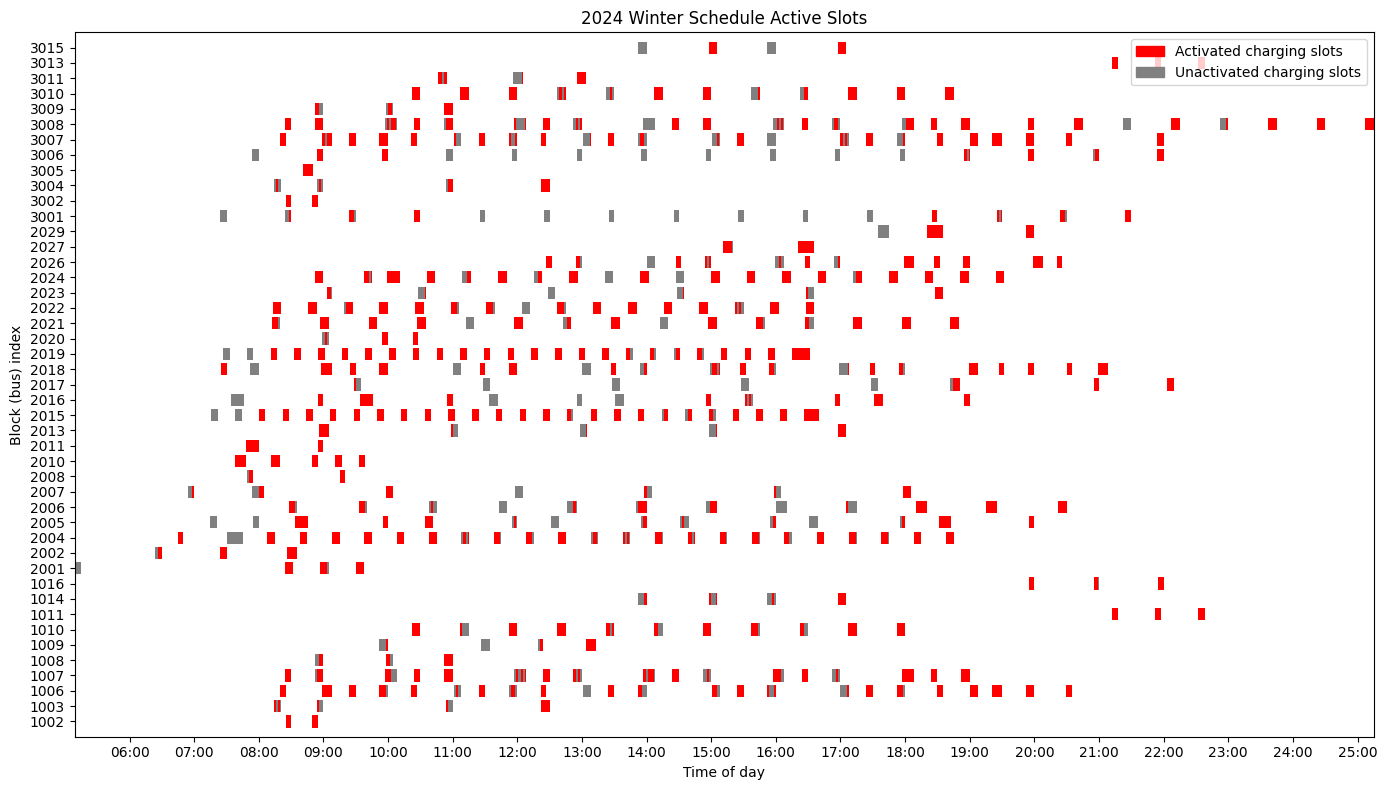

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import BrokenBarHCollection
from matplotlib.patches import Patch
import matplotlib.ticker as ticker

rate_kwh_per_min = 5      
x_result_path = "WS_output/x_results.csv"

df = pd.read_csv(x_result_path)
df["slot_len"] = df["q_kwh"] / rate_kwh_per_min

bus_ids = sorted(df["bus_id"].unique())
bus_map = {bid: idx for idx, bid in enumerate(bus_ids)}
df["bus_index"] = df["bus_id"].map(bus_map)

active = df[df["x"] > 0.5].copy()
inactive = df[df["x"] <= 0.5].copy()

fig, ax = plt.subplots(figsize=(14, 8))

def add_bars(sub_df, color):
    for bus_idx, g in sub_df.groupby("bus_index"):
        bars = list(zip(g["slot_start_min"], g["slot_len"]))
        if not bars:
            continue
        coll = BrokenBarHCollection(
            bars,
            (bus_idx - 0.4, 0.8),    
            facecolors=color,
            edgecolors="none",
        )
        ax.add_collection(coll)

add_bars(inactive, "red")
add_bars(active, "grey")

xmin = df["slot_start_min"].min()
xmax = (df["slot_start_min"] + df["slot_len"]).max()
ax.set_xlim(xmin, xmax)
ax.set_ylim(-1, len(bus_ids))

def minutes_to_hhmm(x, pos):
    h = int(x // 60)
    m = int(x % 60)
    return f"{h:02d}:{m:02d}"

ax.xaxis.set_major_locator(ticker.MultipleLocator(60))  # hour ticks
ax.xaxis.set_major_formatter(ticker.FuncFormatter(minutes_to_hhmm))

ax.set_xlabel("Time of day")
ax.set_ylabel("Block (bus) index")
ax.set_yticks(range(len(bus_ids)))
ax.set_yticklabels(bus_ids)

legend_patches = [
    Patch(color="red", label="Activated charging slots"),
    Patch(color="grey", label="Unactivated charging slots"),
]
ax.legend(handles=legend_patches, loc="upper right")

plt.title("2024 Winter Schedule Active Slots")
plt.tight_layout()
plt.show()


## SOC for Specific Bus in a Day

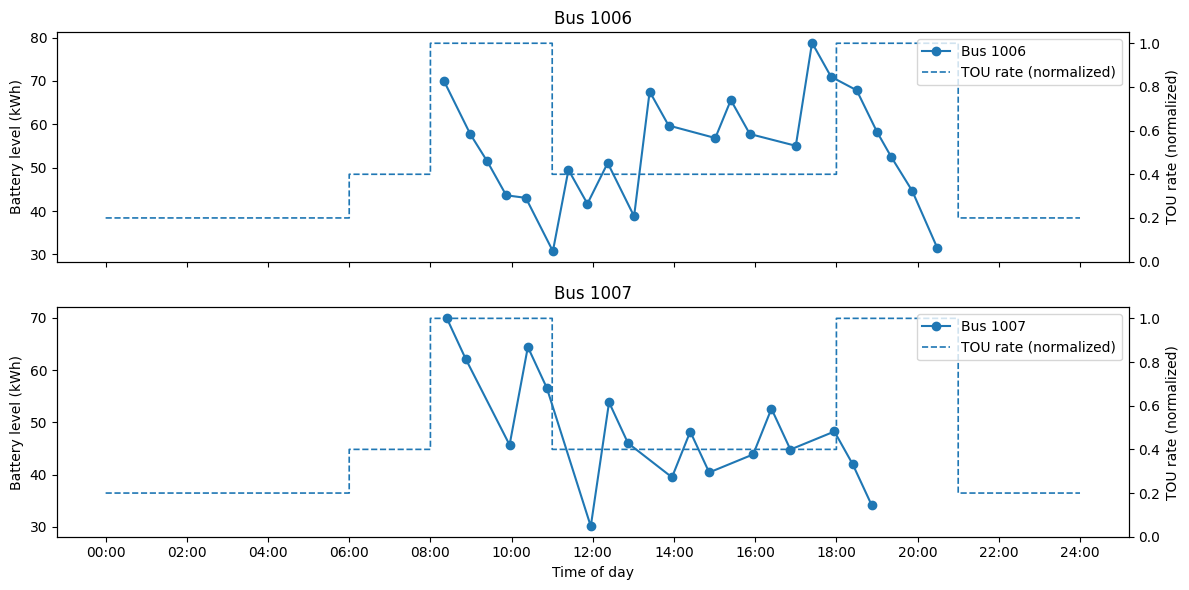

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# ----------------- parameters -----------------
b_results_path = "WS_output/b_results.csv"
input_path = "WS_input.csv"
bus_list = [1006, 1007]       # buses to plot
total_minutes = 1440
tou_prices = (0.1, 0.2, 0.5)  # (off, flat, peak) – same as in the MILP
# ------------------------------------------------

# ---------- helper: TOU price as function of minute ----------
off, flat, peak = tou_prices

def c_at_minute(m):
    # same partition as in your optimization code
    peak_1_start = int(total_minutes * 8 / 24)
    peak_1_end   = int(total_minutes * 11 / 24)
    peak_2_start = int(total_minutes * 18 / 24)
    peak_2_end   = int(total_minutes * 21 / 24)
    flat_1_start = int(total_minutes * 6 / 24)
    flat_1_end   = peak_1_start
    flat_2_start = peak_1_end
    flat_2_end   = peak_2_start
    if (peak_1_start <= m < peak_1_end) or (peak_2_start <= m < peak_2_end):
        return peak
    elif (flat_1_start <= m < flat_1_end) or (flat_2_start <= m < flat_2_end):
        return flat
    else:
        return off

# ---------- load data ----------
bdf = pd.read_csv(b_results_path)   # columns: bus_id, window_id, b_kwh

idf = pd.read_csv(input_path)
idf = idf.rename(columns={"v_num_id": "bus_id", "ki": "window_id"})
idf["bus_id"] = idf["bus_id"].astype(int)
idf["window_id"] = idf["window_id"].astype(int)
idf["start_time"] = idf["start_time"].astype(int)

# one start_time per (bus_id, window_id)
window_times = (
    idf[["bus_id", "window_id", "start_time"]]
    .drop_duplicates()
)

# merge SOC with time
bdf = bdf.merge(window_times, on=["bus_id", "window_id"], how="left")

# ---------- plotting ----------
def minutes_to_hhmm(x, pos):
    h = int(x // 60)
    m = int(x % 60)
    return f"{h:02d}:{m:02d}"

fig, axes = plt.subplots(len(bus_list), 1, figsize=(12, 6), sharex=True)

if len(bus_list) == 1:
    axes = [axes]

# pre-compute TOU curve over whole day (normalized)
times = range(0, total_minutes + 1)
prices = [c_at_minute(t) for t in times]
max_price = max(prices)
prices_norm = [p / max_price for p in prices]  # for right y-axis 0–1 range

for ax, bus in zip(axes, bus_list):
    sub = bdf[bdf["bus_id"] == bus].copy()
    sub = sub.sort_values("start_time")

    # SOC trajectory
    ax.plot(sub["start_time"], sub["b_kwh"],
            marker="o", linewidth=1.5, label=f"Bus {bus}")
    ax.set_ylabel("Battery level (kWh)")
    ax.set_title(f"Bus {bus}")

    # TOU on secondary axis
    ax2 = ax.twinx()
    ax2.step(times, prices_norm, where="post",
             linestyle="--", linewidth=1.2, color="tab:blue",
             label="TOU rate (normalized)")
    ax2.set_ylim(0, 1.05)
    ax2.set_ylabel("TOU rate (normalized)")

    # legend: combine both axes
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

# x-axis formatting
axes[-1].set_xlabel("Time of day")
axes[-1].xaxis.set_major_locator(ticker.MultipleLocator(120))
axes[-1].xaxis.set_major_formatter(ticker.FuncFormatter(minutes_to_hhmm))

plt.tight_layout()
plt.show()


## Station Loads

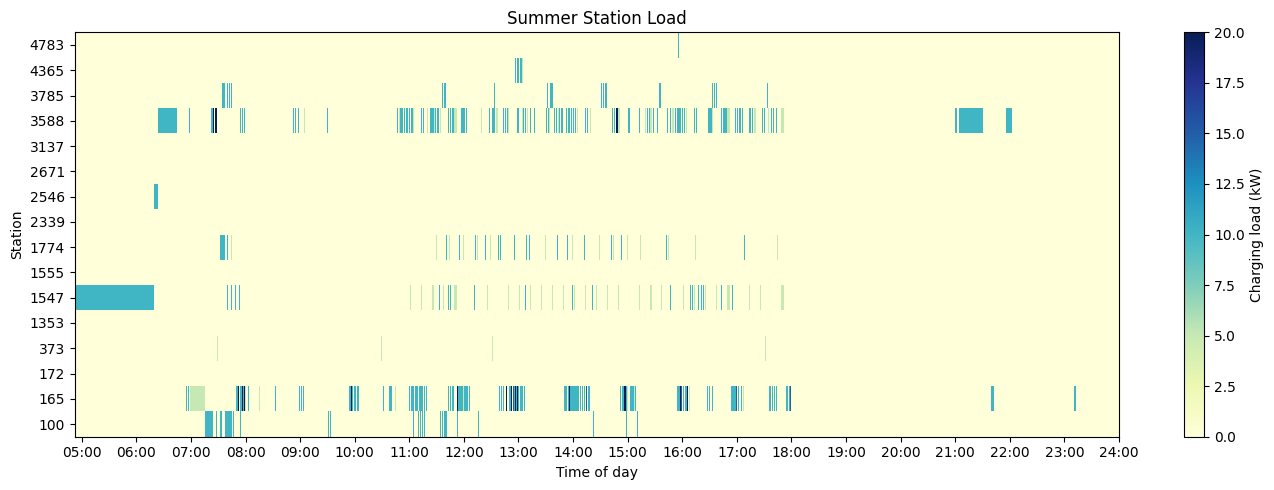

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# ----------- parameters -----------
x_result_path = "SU_output/x_results.csv"
slot_duration_minutes = 2        # your MILP slot length

df = pd.read_csv(x_result_path)

# power in kW for each record
df["power_kw"] = df["x"] * df["q_kwh"]

# aggregate per station and slot
agg = (
    df.groupby(["station_id", "slot_start_min"])["power_kw"]
      .sum()
      .reset_index()
)

stations = sorted(df["station_id"].unique())
times = sorted(df["slot_start_min"].unique())

# pivot to matrix: rows=stations, cols=times
heat = (
    agg.pivot(index="station_id", columns="slot_start_min", values="power_kw")
       .reindex(index=stations, columns=times)
       .fillna(0.0)
)

# ---- build edges for pcolormesh ----
# x: time edges in minutes [t0, t1, ..., t_last + slot_duration]
time_edges = np.array(times + [times[-1] + slot_duration_minutes])
# y: station index edges 0..N
station_edges = np.arange(len(stations) + 1)

fig, ax = plt.subplots(figsize=(14, 5))

# pcolormesh expects (len(y_edges)-1, len(x_edges)-1) array → heat.values fits
pcm = ax.pcolormesh(
    time_edges,
    station_edges,
    heat.values,
    cmap="YlGnBu",
    shading="flat"
)

# y-axis: station labels centered on cells
ax.set_yticks(station_edges[:-1] + 0.5)
ax.set_yticklabels(stations)
ax.set_ylabel("Station")

# x-axis: time of day
def minutes_to_hhmm(x, pos):
    x = int(x)
    h = x // 60
    m = x % 60
    return f"{h:02d}:{m:02d}"

ax.set_xlim(time_edges[0], time_edges[-1])
ax.xaxis.set_major_locator(ticker.MultipleLocator(60)) 
ax.xaxis.set_major_formatter(ticker.FuncFormatter(minutes_to_hhmm))
ax.set_xlabel("Time of day")

# colorbar
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label("Charging load (kW)")

plt.title("Summer Station Load")
plt.tight_layout()
plt.show()


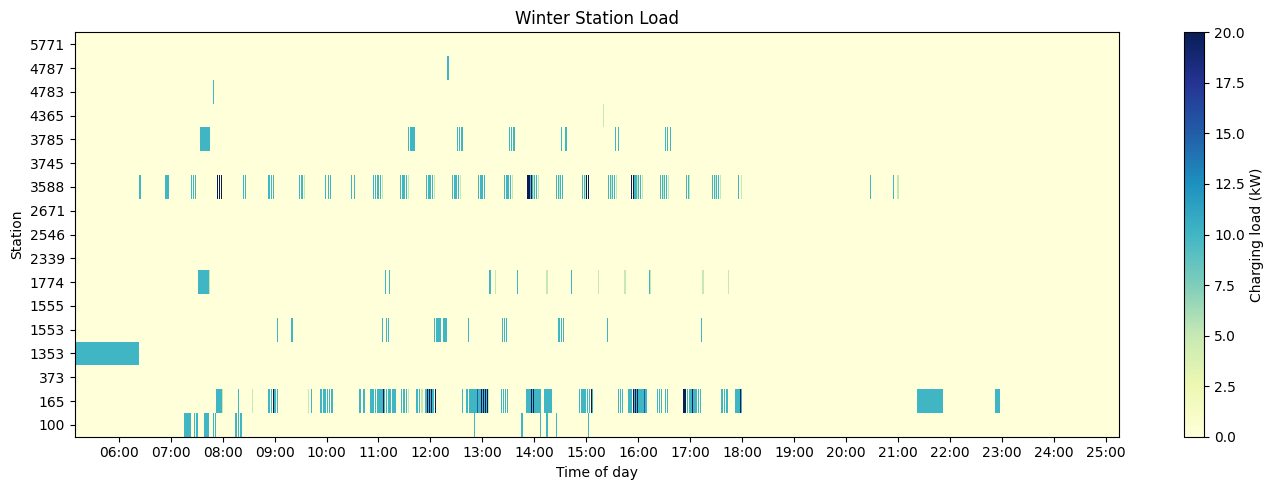

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# ----------- parameters -----------
x_result_path = "WS_output/x_results.csv"
slot_duration_minutes = 2        # your MILP slot length

df = pd.read_csv(x_result_path)

# power in kW for each record
df["power_kw"] = df["x"] * df["q_kwh"]

# aggregate per station and slot
agg = (
    df.groupby(["station_id", "slot_start_min"])["power_kw"]
      .sum()
      .reset_index()
)

stations = sorted(df["station_id"].unique())
times = sorted(df["slot_start_min"].unique())

# pivot to matrix: rows=stations, cols=times
heat = (
    agg.pivot(index="station_id", columns="slot_start_min", values="power_kw")
       .reindex(index=stations, columns=times)
       .fillna(0.0)
)

# ---- build edges for pcolormesh ----
# x: time edges in minutes [t0, t1, ..., t_last + slot_duration]
time_edges = np.array(times + [times[-1] + slot_duration_minutes])
# y: station index edges 0..N
station_edges = np.arange(len(stations) + 1)

fig, ax = plt.subplots(figsize=(14, 5))

# pcolormesh expects (len(y_edges)-1, len(x_edges)-1) array → heat.values fits
pcm = ax.pcolormesh(
    time_edges,
    station_edges,
    heat.values,
    cmap="YlGnBu",
    shading="flat"
)

# y-axis: station labels centered on cells
ax.set_yticks(station_edges[:-1] + 0.5)
ax.set_yticklabels(stations)
ax.set_ylabel("Station")

# x-axis: time of day
def minutes_to_hhmm(x, pos):
    x = int(x)
    h = x // 60
    m = x % 60
    return f"{h:02d}:{m:02d}"

ax.set_xlim(time_edges[0], time_edges[-1])
ax.xaxis.set_major_locator(ticker.MultipleLocator(60))  # every hour
ax.xaxis.set_major_formatter(ticker.FuncFormatter(minutes_to_hhmm))
ax.set_xlabel("Time of day")

# colorbar
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label("Charging load (kW)")

plt.title("Winter Station Load")
plt.tight_layout()
plt.show()